In [190]:
using Agents
using CairoMakie
using Makie

using GeometryBasics
using Random
using LinearAlgebra
using Plots
using KernelDensity
using QuadGK
using Interpolations
using StatsBase
using DataFrames

In [48]:
@agent Bird ContinuousAgent{2} begin
    #id, pos, vel (inherited)
    speed::Float64 #how far it travels
    cohere_factor::Float64 #group cohesion importance
    separation::Float64 #minimum distance from neighbors
    separate_factor::Float64 #importance of separation maintanence
    match_factor::Float64 #importance of maintaining similar trajectories
    visual_distance::Float64 #how far agent sees/scan neighbors (radius)
    ensemble::Float64 #number of birds in the flock the bird belongs to
end

In [198]:
SEED = 12;

In [50]:
model_iteration = 0

function initialize_model(; n_birds = 40,
    speed = 2.0,
    cohere_factor = 0.4,
    separation = 4.0, separate_factor = 0.25,
    match_factor = 0.02,
    visual_distance = 5.0,
    ensemble = 1,
    extent = (50, 50) )
    
    global model_iteration = 0
    
    space2d = ContinuousSpace(extent; spacing = visual_distance/1.5)
    rng = Random.MersenneTwister(SEED)

    model = ABM(Bird, space2d; rng, scheduler = Schedulers.Randomly())
    
    for _ in 1:n_birds
        vel = Tuple(rand(model.rng, 2) * 2 .- 1)
        add_agent!(
            model,
            vel,
            speed,
            cohere_factor,
            separation,
            separate_factor,
            match_factor,
            visual_distance,
            ensemble
        )
    end
    return model
end


initialize_model (generic function with 1 method)

In [51]:
model = initialize_model()

StandardABM with 40 agents of type Bird
 space: periodic continuous space with (50.0, 50.0) extent and spacing=3.3333333333333335
 scheduler: Agents.Schedulers.Randomly

In [174]:
90 * (pi / 180)

1.5707963267948966

In [194]:
function agent_step!(bird, model)
    # Obtain the ids of neighbors within the bird's visual distance
    neighbor_ids = nearby_ids(bird, model, bird.visual_distance)
    N = 0
    match = separate = cohere = (0.0, 0.0)
    
    angle_threshold = 120 * (pi / 180)
    bird_speed = norm(bird.vel)
    ensemble_count = 0
        
    for id in neighbor_ids
        N += 1
        neighbor = model[id].pos
        heading = neighbor .- bird.pos

        # `cohere` computes the average position of neighboring birds
        cohere = cohere .+ heading

        if euclidean_distance(bird.pos, neighbor, model) < bird.separation
            # `separate` repels the bird away from neighboring birds
            separate = separate .- heading
        end
        # `match` computes the average trajectory of neighboring birds
        match = match .+ model[id].vel
        
        #ensemble energy stuff
        neighbor_speed = norm(model[id].speed)        
        angle_between = acos(dot(bird.vel, model[id].vel) / (bird_speed * neighbor_speed + 1e-9))  # Adding a small epsilon to avoid division by zero
        speed_difference = abs(bird_speed - neighbor_speed) / (bird_speed + 1e-9)  # Adding a small epsilon to avoid division by zero
        
#         print(angle_between,", ")
#         println("Angle: $angle_between, Speed Diff: $speed_difference")
        if angle_between < angle_threshold #|| (speed_difference < 2 || speed_difference > 0.5)
            ensemble_count += 1
        end        
                
    end
    N = max(N, 1)
    
    # Normalise results based on model input and neighbor count
    cohere = cohere ./ N .* bird.cohere_factor
    separate = separate ./ N .* bird.separate_factor
    
    match = match ./ N .* bird.match_factor
    # Compute velocity based on rules defined above
    bird.vel = (bird.vel .+ cohere .+ separate .+ match) ./ 2
    bird.vel = bird.vel ./ norm(bird.vel)
    # Move bird according to new velocity and speed
    
    bird.ensemble = ensemble_count
    
    move_agent!(bird, model, bird.speed)
end

agent_step! (generic function with 1 method)

In [153]:
bird_polygon = Makie.Polygon(Point2f[(-1, -1), (2, 0), (-1, 1)])

function bird_marker(b::Bird)
    φ = atan(b.vel[2], b.vel[1]) #+ π/2 + π
    rotate_polygon(bird_polygon, φ)
end

function Plot_Birds_Iter(model, heat_tmp, iteration_tmp)    
    title_str = "E=$heat_tmp at iter=$iteration_tmp"
    figure, = Agents.abmplot(model; am = bird_marker, aspect = 1, 
                                axis = (; title = title_str, titlesize=20) )
    return figure    
end


Plot_Birds_Iter (generic function with 1 method)

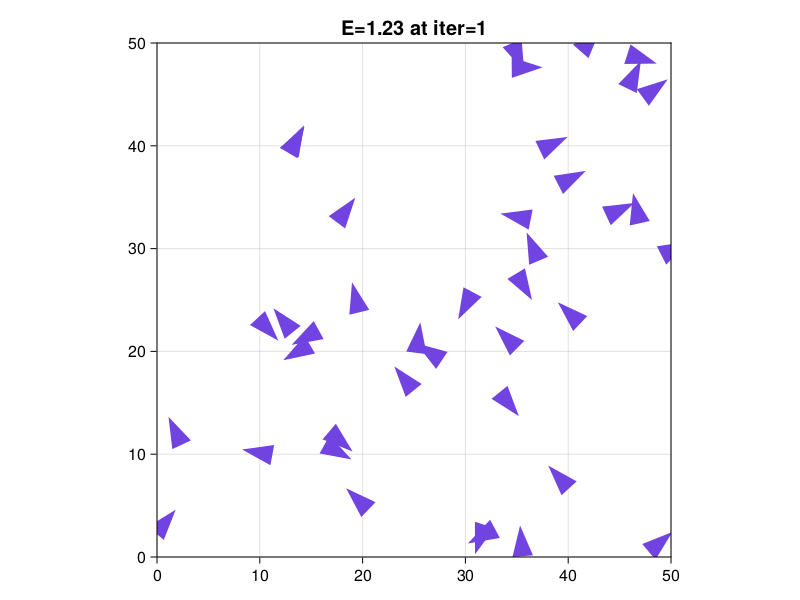

In [154]:
Plot_Birds_Iter(initialize_model(), 1.23, 1)

## Energies



In [155]:
function Model_Ensemble_Energy(model)
    energy = 0
    
    for bird in allagents(model)        
        energy += bird.ensemble
    end
    
    return energy
end

Model_Ensemble_Energy (generic function with 1 method)

In [156]:
function Model_Energy_DistributionFN(model) 
    energies = []

    for bird in allagents(model)
        push!(energies, bird.ensemble)
    end
    
    energies_float = float.(energies)

    hist = fit(Histogram, energies_float, closed=:left)

    total_count = sum(hist.weights)
    pdf = hist.weights ./ total_count

    # This will include the bin centers (or edges) and the corresponding probabilities
    energy_bins = midpoints(hist.edges[1])
    energy_distribution = [(e, p) for (e, p) in zip(energy_bins, pdf)]

    return energy_distribution
end

Model_Energy_DistributionFN (generic function with 1 method)

In [157]:
function Model_Entropy(e_p_array)
    S = 0.0

    for (e, p) in e_p_array
        # Only add to the sum if p is non-zero to avoid log(0)
        if p > 0
            S -= p * log(p)
        end
    end

    return S  
end

Model_Entropy (generic function with 1 method)

In [158]:
# T = -((\int_{E_min}^{E_max} (dp(E)/dE) * ln(p(E)) dE)^-1 
# summation in discrete situation
# p(E) the probability distribution of the energies E, and E_min and E_max 
function Model_Temperature(e_p_array)
    sum_result = 0.0
    
    # Iterate through the e_p_array to approximate the integral using finite differences
    for i in 2:length(e_p_array)
        E_prev, p_prev = e_p_array[i - 1]
        E, p = e_p_array[i]

        # Compute the finite difference approximation of dp/dE
        delta_E = E - E_prev
        dp_dE = (p - p_prev) / delta_E

        # Only consider non-zero probabilities to avoid logarithm of zero
        if p > 0
            sum_result += dp_dE * log(p)
        end
    end
    
    # Handle the case where the sum_result is zero to avoid division by zero
    if sum_result == 0
        return 0  # Return infinity if the sum is zero, indicating a very high temperature
    else
        T = -1 / sum_result
        return abs(T)
    end
end


Model_Temperature (generic function with 1 method)

In [159]:
function Model_Heat(S_current, S_prev, T_current)
    dS = S_current - S_prev
    dQ = abs(T_current) * abs(dS)
    return dQ
end

Model_Heat (generic function with 2 methods)

In [160]:
global S_prev;

function Model_Thermo_State(model)
    
    e_p_array = Model_Energy_DistributionFN(model)
    S = Model_Entropy(e_p_array)
    T = Model_Temperature(e_p_array)
    
    dQ = 0;
    
    if(model_iteration > 0)
        dQ = Model_Heat(S, S_prev, T)
    end
    
    global S_prev = S;
    
    return Dict("S"=>S,"T"=>T,"dQ"=>dQ)
end

Model_Thermo_State (generic function with 1 method)

In [161]:
function Flock_Model_State(model)
    energy = Model_Ensemble_Energy(model)
    fig_tmp = Plot_Birds_Iter(model, energy, model_iteration)
    return fig_tmp
end

Flock_Model_State (generic function with 1 method)

In [162]:
function model_step!(model)
    global model_iteration += 1    
end

model_step! (generic function with 1 method)

In [163]:
function Step_Num(model)
    return model_iteration 
end

Step_Num (generic function with 1 method)

In [199]:
model = initialize_model()

adata = [ :separation, :speed, :ensemble ]
mdata = [ Step_Num, Model_Ensemble_Energy, Model_Thermo_State, Flock_Model_State ]

step_num = 100
agent_df, model_df = run!(model, agent_step!, model_step!, step_num; adata , mdata);

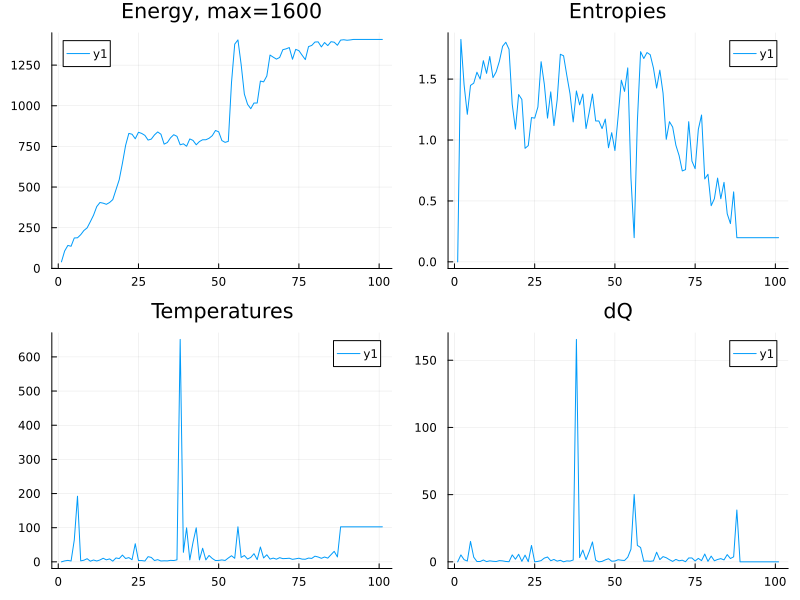

In [200]:
p1 = Plots.plot( model_df[ :, :Model_Ensemble_Energy], title="Energy, max=$(40^2)" )

S_vals = model_df[ :, :Model_Thermo_State] .|> x -> x["S"]
p2 = Plots.plot( S_vals, title="Entropies" )

T_vals = model_df[ :, :Model_Thermo_State] .|> x -> x["T"]
p3 = Plots.plot( T_vals, title="Temperatures" )

dQ_vals = model_df[ :, :Model_Thermo_State] .|> x -> x["dQ"]
p4 = Plots.plot( dQ_vals, title="dQ" )

Plots.plot(p1,p2,p3,p4, size=(800,600))

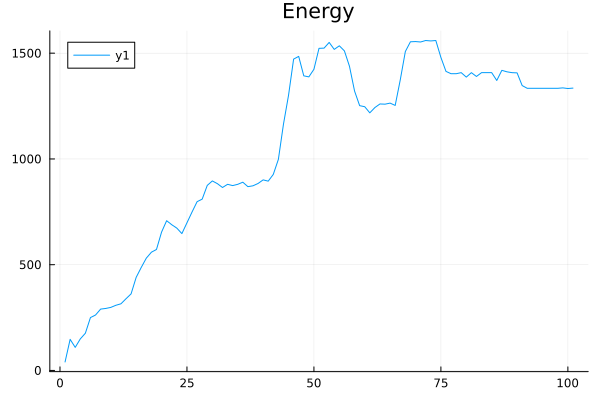

In [77]:
Plots.plot( model_df[ :, :Model_Ensemble_Energy], title="Energy" )

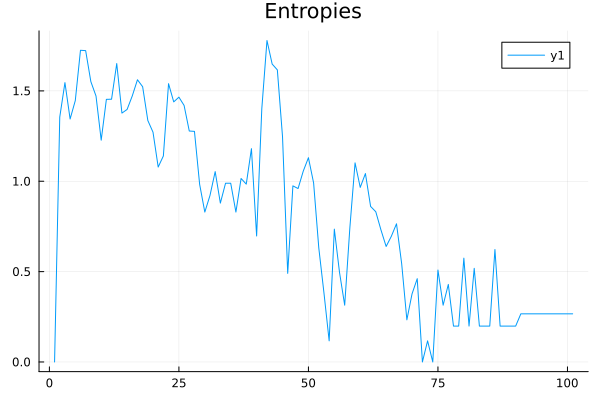

In [79]:
S_vals = model_df[ :, :Model_Thermo_State] .|> x -> x["S"]
Plots.plot( S_vals, title="Entropies" )

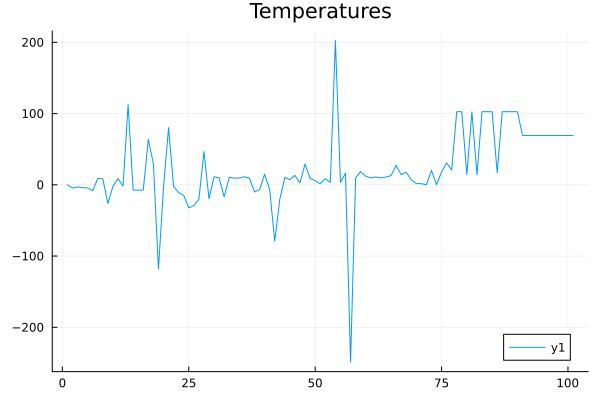

In [80]:
T_vals = model_df[ :, :Model_Thermo_State] .|> x -> x["T"]
Plots.plot( T_vals, title="Temperatures" )

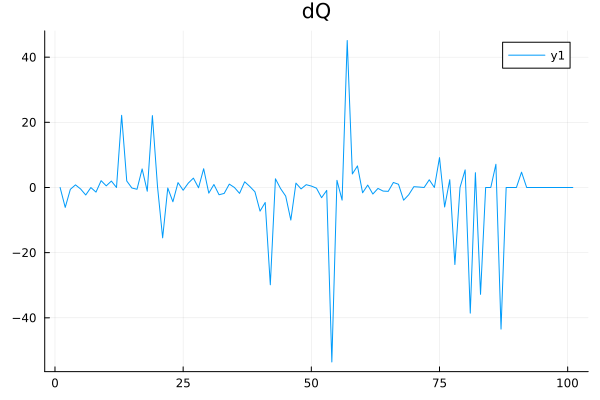

In [83]:
dQ_vals = model_df[ :, :Model_Thermo_State] .|> x -> x["dQ"]
Plots.plot( dQ_vals, title="dQ" )

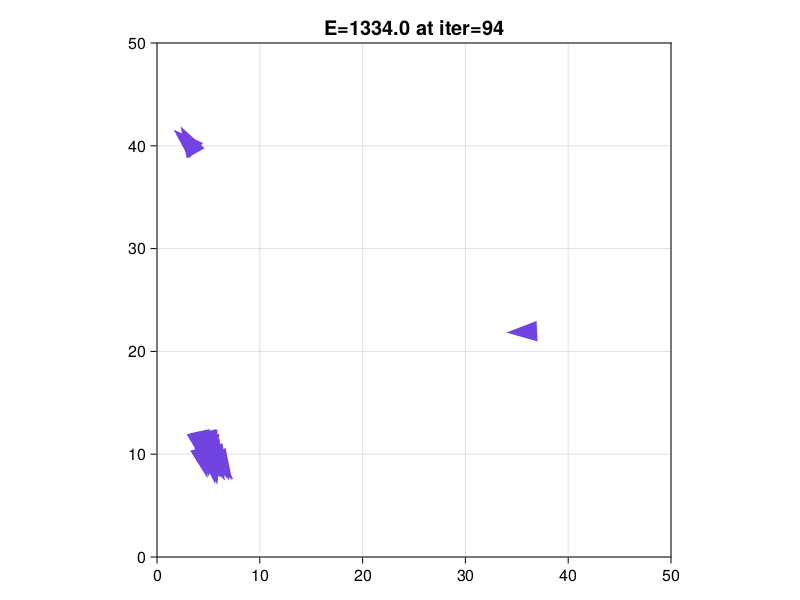

In [180]:
model_df[ 95, :Flock_Model_State]